# Q 2.4.17. Standard Gradient Descent vs. Natural Gradient Descent
In this notebbook, we compare standard gradient descent (GD) and natural gradient descent (NGD) for estimating the parameters of a 1D Gamma distribution from observed data. We will generate synthetic data from a known Gamma distribution and then attempt to recover its shape and scale parameters using both optimization methods.

# 1. Configuration
We define the true parameters of the Gamma distribution, the number of data points to generate, the learning rate, the number of epochs for optimization, and the initial guesses for the parameters. We also set a random seed for reproducibility.

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Gamma
# ------------------------

# True parameters of the Gamma distribution we want to discover
ALPHA_TRUE = 3.0   # shape
BETA_TRUE  = 2.0   # scale

# Number of observed data points
N_DATA = 1000

# Optimization parameters
LEARNING_RATE = 0.1
EPOCHS = 2000

# Initial "wrong" guess for our parameters (still positive)
ALPHA_INIT = 0.5
BETA_INIT  = 8.0

# Fix random seed for reproducibility (optional)
torch.manual_seed(0)


# 2. Data Generation
We generate synthetic data from the true Gamma distribution using PyTorch's `Gamma` distribution class. We sample `N_DATA` points and print the sample mean and variance to verify the generated data.

In [9]:
# Our parameterisation is shape–scale, but PyTorch's Gamma uses shape–rate.
rate_true = 1.0 / BETA_TRUE
dist_true = Gamma(concentration=torch.tensor(ALPHA_TRUE),
                  rate=torch.tensor(rate_true))

data = dist_true.sample((N_DATA,))

print(f"Generated {N_DATA} data points from Gamma(alpha={ALPHA_TRUE}, beta={BETA_TRUE})")
print(f"Sample mean:     {data.mean().item():.4f}")
print(f"Sample variance: {data.var().item():.4f}\n")



Generated 1000 data points from Gamma(alpha=3.0, beta=2.0)
Sample mean:     6.0692
Sample variance: 11.9481



# 3. Loss function & parameter init
We define the negative log-likelihood loss function for the Gamma distribution. We also initialize the parameters for both standard gradient descent and natural gradient descent, and set up history trackers to record the parameter values over epochs.

In [10]:
# ToDo: Loss function
def gamma_nll(alpha, beta, data_points):
    """
    ToDo:
        Implement the average negative log-likelihood for Gamma distribution with shape=alpha and scale=beta.

        Hints:
        - Enforce positivity using clamp (e.g. min=1e-4).
        - PyTorch's Gamma takes (concentration=alpha, rate=1/beta).
        - Return the *mean* negative log-likelihood.

    """
    alpha = torch.clamp(alpha, min=1e-4)
    beta = torch.clamp(beta, min=1e-4)
    rate = 1.0 / beta
    dist = Gamma(concentration=alpha, rate=rate)
    nll = -dist.log_prob(data_points).mean()
    return nll


In [11]:

# Parameters for Standard Gradient Descent (GD)
alpha_gd = torch.tensor(ALPHA_INIT, requires_grad=True)
beta_gd  = torch.tensor(BETA_INIT,  requires_grad=True)

# Parameters for Natural Gradient Descent (NGD)
alpha_ngd = torch.tensor(ALPHA_INIT, requires_grad=True)
beta_ngd  = torch.tensor(BETA_INIT,  requires_grad=True)

# History trackers
history_gd  = []
history_ngd = []

# 4. Fisher Information inverse

In [12]:
def fisher_inverse(alpha, beta):
    """
    TODO:
      Implement the inverse Fisher Information matrix F^{-1}(α, β)
      for the Gamma(shape=α, scale=β) distribution.

      Theory:
        F(α, β) =
            [ ψ1(α)        1/β      ]
            [  1/β     α/β^2        ]

        F^{-1}(α, β) =
            1 / (α ψ1(α) - 1) *
            [  α           -β             ]
            [  -β       β^2 ψ1(α)         ]

      Hints:
      - Use torch.polygamma(1, alpha) for ψ1(α) (trigamma).
      - Make sure to detach alpha, beta so F^{-1} is not part of the graph.
    """
    #complete
    factor = 1.0 / (alpha * torch.polygamma(1, alpha) - 1)
    inv11 = (factor * alpha).detach()
    inv12 = (factor * -beta).detach()
    inv22 = (factor * beta**2 * torch.polygamma(1, alpha)).detach()
    return inv11, inv12, inv22

# 4. Optimization Loop
We run the optimization loop for a specified number of epochs. In each epoch, we perform both standard gradient descent and natural gradient descent updates. We compute the gradients, build the Fisher Information Matrix for NGD, and update the parameters accordingly. We also log the parameter values and losses at regular intervals.

In [13]:
print(f"Optimizing with LR={LEARNING_RATE} for {EPOCHS} epochs...")

for epoch in range(EPOCHS):

    # ===== A. Standard Gradient Descent (GD) =====

    if alpha_gd.grad is not None:
        alpha_gd.grad.zero_()
    if beta_gd.grad is not None:
        beta_gd.grad.zero_()

    loss_gd = gamma_nll(alpha_gd, beta_gd, data)
    loss_gd.backward()

    with torch.no_grad():
        alpha_gd -= LEARNING_RATE * alpha_gd.grad
        beta_gd  -= LEARNING_RATE * beta_gd.grad

        alpha_gd.clamp_(min=1e-4)
        beta_gd.clamp_(min=1e-4)

    history_gd.append((alpha_gd.item(), beta_gd.item()))

    # ===== B. Natural Gradient Descent (NGD) =====

    if alpha_ngd.grad is not None:
        alpha_ngd.grad.zero_()
    if beta_ngd.grad is not None:
        beta_ngd.grad.zero_()

    loss_ngd = gamma_nll(alpha_ngd, beta_ngd, data)
    loss_ngd.backward()

    g_alpha = alpha_ngd.grad
    g_beta  = beta_ngd.grad

    # ToDo : compute natural gradient using F^{-1}(α, β)
    #  1) Get F^{-1} entries using fisher_inverse(...)
    #  2) Compute:
    #       - ng_alpha
    #       - ng_beta

    inv11, inv12, inv22 = fisher_inverse(alpha_ngd, beta_ngd)

    ng_alpha =  inv11 * g_alpha + inv12 * g_beta
    ng_beta  =  inv12 * g_alpha + inv22 * g_beta

    with torch.no_grad():
        alpha_ngd -= LEARNING_RATE * ng_alpha
        beta_ngd  -= LEARNING_RATE * ng_beta

        alpha_ngd.clamp_(min=1e-4)
        beta_ngd.clamp_(min=1e-4)

    history_ngd.append((alpha_ngd.item(), beta_ngd.item()))

    if (epoch + 1) % 15 == 0 or epoch == 0:
        print(f"\n--- Epoch {epoch + 1} ---")
        print(f"  GD:  alpha={alpha_gd.item():.4f}, beta={beta_gd.item():.4f}, "
              f"Loss={loss_gd.item():.4f}")
        print(f"  NGD: alpha={alpha_ngd.item():.4f}, beta={beta_ngd.item():.4f}, "
              f"Loss={loss_ngd.item():.4f}")


print("\nOptimization finished.")



Optimizing with LR=0.1 for 2000 epochs...

--- Epoch 1 ---
  GD:  alpha=0.6516, beta=8.0032, Loss=3.1866
  NGD: alpha=0.5340, beta=7.8695, Loss=3.1866

--- Epoch 15 ---
  GD:  alpha=1.0504, beta=7.9743, Loss=2.8331
  NGD: alpha=1.2770, beta=4.3331, Loss=2.7370

--- Epoch 30 ---
  GD:  alpha=1.0853, beta=7.9160, Loss=2.8296
  NGD: alpha=2.3102, beta=2.5556, Loss=2.5688

--- Epoch 45 ---
  GD:  alpha=1.0933, beta=7.8551, Loss=2.8270
  NGD: alpha=2.8686, beta=2.1013, Loss=2.5450

--- Epoch 60 ---
  GD:  alpha=1.0989, beta=7.7937, Loss=2.8245
  NGD: alpha=3.0273, beta=2.0018, Loss=2.5435

--- Epoch 75 ---
  GD:  alpha=1.1045, beta=7.7319, Loss=2.8219
  NGD: alpha=3.0627, beta=1.9810, Loss=2.5434

--- Epoch 90 ---
  GD:  alpha=1.1101, beta=7.6698, Loss=2.8193
  NGD: alpha=3.0701, beta=1.9768, Loss=2.5434

--- Epoch 105 ---
  GD:  alpha=1.1159, beta=7.6072, Loss=2.8167
  NGD: alpha=3.0716, beta=1.9759, Loss=2.5434

--- Epoch 120 ---
  GD:  alpha=1.1217, beta=7.5444, Loss=2.8141
  NGD: alpha=

# Q 2.4.18. Plotting Results
To illustrate the difference between standard gradients and natural gradients, we print out the gradients computed in the first epoch for both methods.

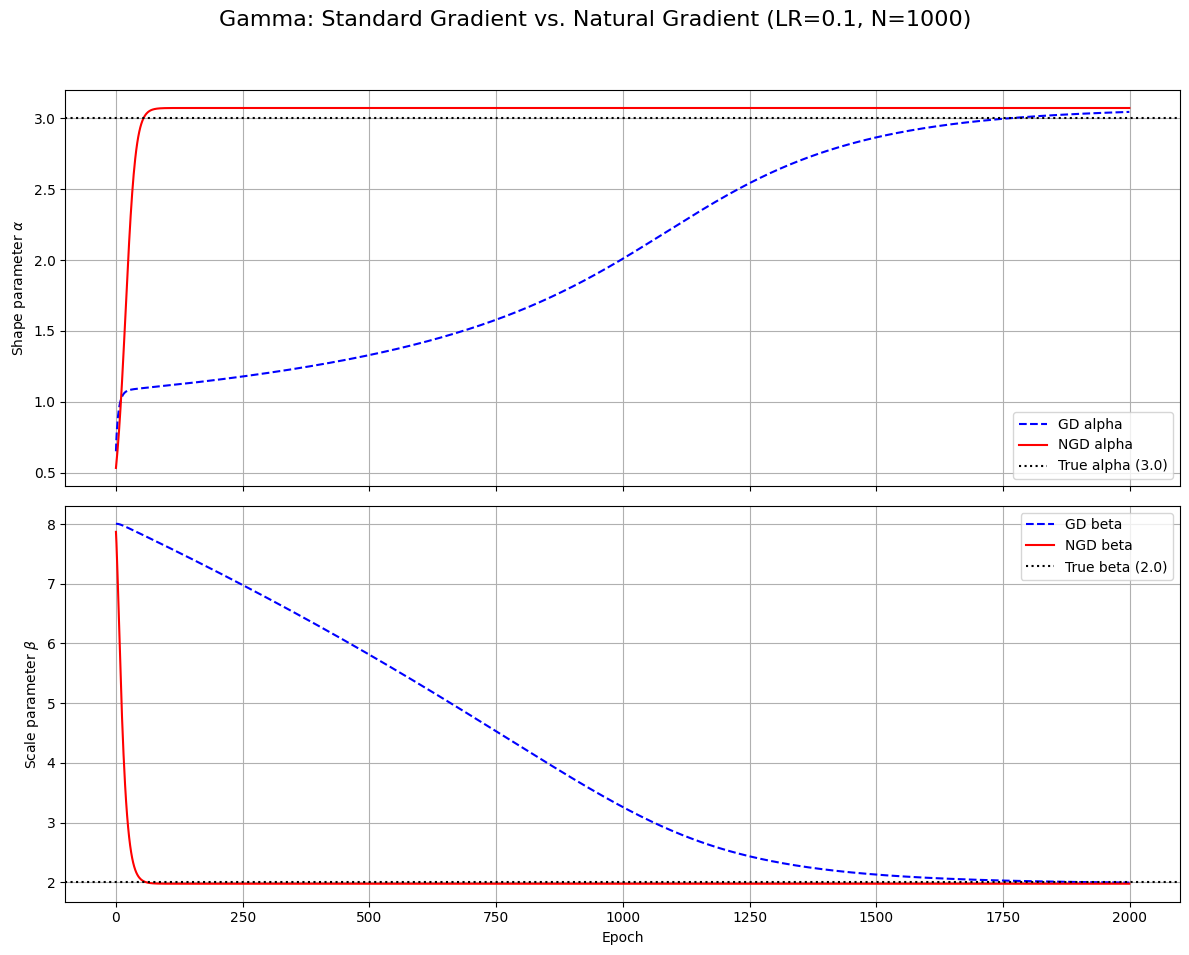

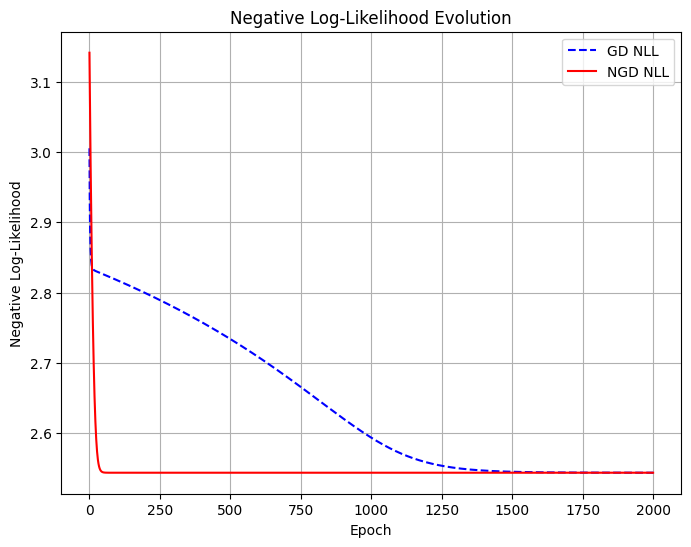

In [14]:

hist_gd_np  = np.array(history_gd)
hist_ngd_np = np.array(history_ngd)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle(f"Gamma: Standard Gradient vs. Natural Gradient "
             f"(LR={LEARNING_RATE}, N={N_DATA})", fontsize=16)

# Plot 1: alpha (shape)
ax1.plot(hist_gd_np[:, 0],  label="GD alpha",  color='blue', linestyle='--')
ax1.plot(hist_ngd_np[:, 0], label="NGD alpha", color='red')
ax1.axhline(ALPHA_TRUE, color='black', linestyle=':', label=f"True alpha ({ALPHA_TRUE})")
ax1.set_ylabel("Shape parameter $\\alpha$")
ax1.legend()
ax1.grid(True)

# Plot 2: beta (scale)
ax2.plot(hist_gd_np[:, 1],  label="GD beta",  color='blue', linestyle='--')
ax2.plot(hist_ngd_np[:, 1], label="NGD beta", color='red')
ax2.axhline(BETA_TRUE, color='black', linestyle=':', label=f"True beta ({BETA_TRUE})")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Scale parameter $\\beta$")
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Save to Plots directory:
#plt.savefig("Plots/gamma_parameters_evolution.png")
plt.show()

#Plot the evolution of the negative log-likelihoods
fig, ax = plt.subplots(figsize=(8,6))
ax.plot([gamma_nll(torch.tensor(a), torch.tensor(b), data).item() for a, b in history_gd], label='GD NLL', color='blue', linestyle='--')
ax.plot([gamma_nll(torch.tensor(a), torch.tensor(b), data).item() for a, b in history_ngd], label='NGD NLL', color='red')
ax.set_xlabel('Epoch')
ax.set_ylabel('Negative Log-Likelihood')
ax.set_title('Negative Log-Likelihood Evolution')
ax.legend()
ax.grid(True)
# Save to Plots directory:
#plt.savefig("Plots/gamma_nll_evolution.png")
plt.show()